In [1]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import pysal as ps
from pysal.contrib.viz import mapping as maps
from pysal.esda.getisord import G_Local
import folium
from folium.plugins import Fullscreen
from pathlib import Path
from shapely.geometry import Point, Polygon
from scr import dopemap
from scr import coordconverter
import shapefile
from json import dumps
import importlib
import seaborn as sns
importlib.reload(dopemap)
pd.set_option('display.max_columns', 500)
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from datetime import date
import numpy as np 
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import warnings
import operator
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)
from difflib import SequenceMatcher


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
data_folder = Path("../../Projets/Fertility/Data/").resolve()
shp_folder = Path("../../Data/Shape_files/").resolve()
output_folder = Path("../../Projets/Fertility/Maps/").resolve()
datatomap = data_folder / "Fertility_27496_geocoded.csv"
# geojson_file = data_folder/"swiss_cities.geojson"

In [3]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
def filter_text(text):
    if text is not None:
        for ch in ['\r','\n','.','/']:
            if ch in text:
                text = text.replace(ch,' ')
        for ch in ['c/o','\r','\n','c.f.','chez']:
            if ch in text.split(' '):
                text = text.replace(ch," ")
        if 'yverdon' in text.split(' '):
            text = text.replace('yverdon',"yverdon-les-bains")
        elif 'ch' in text.split(' '):
            text = text.replace('ch',"chemin")
        elif 'rte' in text.split(' '):
            text = text.replace('rte',"route")
        elif ',' in text:
            text = text.replace(','," , ")
    return text

In [4]:
df = pd.read_csv(datatomap,encoding = 'iso-8859-1')
df['comment'] = ''

In [5]:
df.full_address = df.full_address.str.lower()
df.ADRESSE = df.ADRESSE.str.lower()
df.VILLE = df.VILLE.str.lower()
df.VILLE = df.VILLE.astype(str)
df = df.fillna('')
df.geo_address = df.geo_address.astype(str)
df['CODE.POSTAL'] = df['CODE.POSTAL'].astype(str)


In [6]:
df.head()

,X.U.FEFF.No_SIMED,AGE,DATE.DE.NAISSANCE,ADRESSE,CODE.POSTAL,VILLE,DATE.EXAMEN,VOLUME_SPERME,CONCENTRATION,MOBILITE,full_address,lon,lat,geo_address,comment
1,10429,25,4/2/1961,rue yverdon 21,1530,payerne caserne,8/14/1985,,48,40,rue yverdon 21 1530 payerne caserne suisse,6.93993,46.8214,"rue derrière chapelle, 1530 payerne, switzerland",
2,13649,37,4/7/1951,clos dufour 13,1740,neyruz fr,5/14/1987,,200,20,clos dufour 13 1740 neyruz fr suisse,7.06679,46.7698,"1740 neyruz, switzerland",
3,10971,26,4/5/1960,beaudere 60,1541,bussy,10/31/1985,,20,45,beaudere 60 1541 bussy suisse,6.88837,46.8347,"1541 bussy, switzerland",
4,12445,36,9/27/1962,"25,av reneveyres",1110,morges,1/20/1998,,,,"25,av reneveyres 1110 morges suisse",6.49266,46.5173,"avenue des reneveyres 25, 1110 morges, switzer...",
5,12988,30,9/23/1965,ch. de savoie 4,1305,penthalaz,9/30/1994,,,,ch. de savoie 4 1305 penthalaz suisse,6.52488,46.6146,"chemin de savoie 4, 1305 penthalaz, switzerland",


In [7]:
df['clean_full_address'] = df.apply(lambda x: filter_text(x.full_address), axis=1)
df['clean_address'] = df.apply(lambda x: filter_text(x.ADRESSE), axis=1)
df['similarity'] = df.apply(lambda x: similar(x.geo_address,x.clean_full_address)*100, axis=1)


In [8]:
df['is_geocoded'] = df.apply(lambda x: x.geo_address != '', axis=1)
df['street_num'] = df.apply(lambda x: ''.join(s for s in x.clean_address.split() if s.isdigit()),axis =1)
df['contains_city'] = df.apply(lambda x: x.VILLE in x.geo_address, axis=1)
df['contains_cp'] = df.apply(lambda x: x['CODE.POSTAL'] in x.geo_address, axis=1)
df['is_CH'] = df.apply(lambda x: 'switzerland' in x.geo_address, axis=1)
df['is_address_full'] = df.apply(lambda x: x.geo_address.count(',') ==2, axis=1)
df.street_num = df.street_num.replace(r'', np.nan, regex=True)
df.street_num = df.street_num.astype(str)
df['contains_street_num'] = df.apply(lambda x: x['street_num'] in x.geo_address.split(',')[0], axis=1)
df.loc[df['is_address_full'] == False, 'contains_street_num'] = False


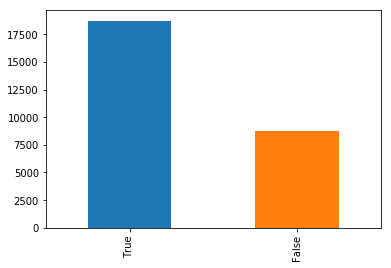

In [9]:
df.contains_street_num.value_counts().plot.bar()

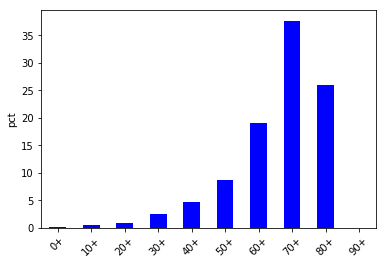

In [10]:
bins=['0+','10+','20+','30+','40+','50+','60+','70+','80+','90+']
out = pd.cut(df.similarity, bins=[0.0, 10.0,20.0, 30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0], include_lowest=True)
out_norm = out.value_counts(sort=False, normalize=True).mul(100)
ax = out_norm.plot.bar(rot=45, color="b", figsize=(6,4))
ax.set_xticklabels(bins)
plt.ylabel("pct")
plt.show()

In [11]:
df_map = df[(df.similarity >= 60.0) & (df.is_address_full == True) & (df.contains_street_num ==True) & (df.geo_address.str.contains('switzerland'))].sort_values('similarity')

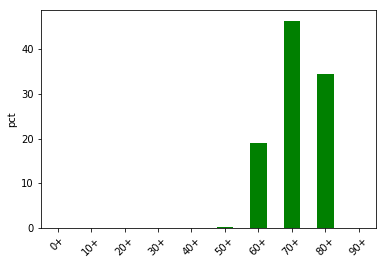

In [12]:
bins=['0+','10+','20+','30+','40+','50+','60+','70+','80+','90+']
out = pd.cut(df_map.similarity, bins=[0.0, 10.0,20.0, 30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0], include_lowest=True)
out_norm = out.value_counts(sort=False, normalize=True).mul(100)
ax = out_norm.plot.bar(rot=45, color="g", figsize=(6,4))
ax.set_xticklabels(bins)
plt.ylabel("pct")
plt.show()





In [13]:
df_map['DATE.EXAMEN'] = pd.to_datetime(df_map['DATE.EXAMEN'])
df_map['YEAR.EXAMEN'] = df_map['DATE.EXAMEN'].dt.year
df_map['MONTH.EXAMEN'] = df_map['DATE.EXAMEN'].dt.month
df_map['DAY.EXAMEN'] = df_map['DATE.EXAMEN'].dt.day

df_map.AGE = df_map.AGE.replace(r'', np.nan, regex=True)
df_map.AGE = df_map.AGE.astype(float)
df_map.CONCENTRATION = df_map.CONCENTRATION.replace('?', '')
df_map.CONCENTRATION = df_map.CONCENTRATION.replace(r'', np.nan, regex=True)
df_map.CONCENTRATION = df_map.CONCENTRATION.astype(float)
df_map.MOBILITE = df_map.MOBILITE.replace(r'', np.nan, regex=True)
df_map.MOBILITE = df_map.MOBILITE.astype(float)
df_map.VOLUME_SPERME = df_map.VOLUME_SPERME.replace(r'', np.nan, regex=True)
df_map.VOLUME_SPERME = df_map.VOLUME_SPERME.astype(float)
df_map = df_map.sort_values('VOLUME_SPERME')
df_map['Rank_pct_vol']= df_map.VOLUME_SPERME.rank(pct=True)*100
df_map['Rank_pct_vol'] = pd.cut(df_map.Rank_pct_vol, bins=[0.0,25.0,50.0,75.0,100.0], include_lowest=True)
df_map.lon = df_map.lon.astype(float)
df_map.lat = df_map.lat.astype(float)
df_map = df_map.reset_index(drop=True)
df_map.Rank_pct_vol = df_map.Rank_pct_vol.astype(str)


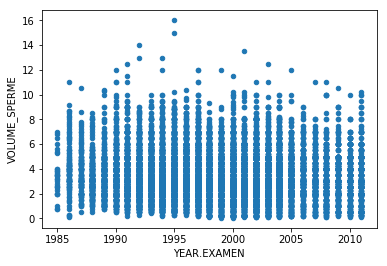

In [14]:
df_map.plot('YEAR.EXAMEN','VOLUME_SPERME',kind = 'scatter')

In [15]:
df_map.Rank_pct_vol.value_counts()

(75.0, 100.0]     4598
(25.0, 50.0]      4584
(50.0, 75.0]      4415
(-0.001, 25.0]    4397
nan                  3
Name: Rank_pct_vol, dtype: int64

In [16]:
colors = ['lightblue','blue','red','darkred','gray']
folium_map = dopemap.createMap(df_map,'lon','lat',10,14)
# Add additional tile style options
folium_map = dopemap.addTiles(folium_map,['Stamen Toner','CartoDB dark_matter'],14)
# Add Circle Markers at designed locations
    # Clustering points
dopemap.createMarkers(folium_map,df_map,'lon','lat','Fertility data points',['VOLUME_SPERME','lon','lat','geo_address','similarity'],['Sperm Volume','Longitud','Latitud','Address','Similarity'],'Rank_pct_vol',20,colors)
#Add legend to markers
legend_html = dopemap.createLegend(folium_map,df_map['Rank_pct_vol'],colors)
# Add heatmap
dopemap.createHeatmap(folium_map,df_map,'lon','lat')
# Add fullscreen option
Fullscreen().add_to(folium_map)
# Add layer control
folium.LayerControl().add_to(folium_map)
# Save map 1A ########################################################################################
output_file = str(output_folder / 'Vol_sperm.html')
folium_map.save(output_file)

0  markers added to the map!
1000  markers added to the map!
2000  markers added to the map!
3000  markers added to the map!
4000  markers added to the map!
5000  markers added to the map!
6000  markers added to the map!
7000  markers added to the map!
8000  markers added to the map!
9000  markers added to the map!
10000  markers added to the map!
11000  markers added to the map!
12000  markers added to the map!
13000  markers added to the map!
14000  markers added to the map!
15000  markers added to the map!
16000  markers added to the map!
17000  markers added to the map!


# Spatial analyses

In [17]:
df_map.is_CH = df_map.is_CH.astype(str)
df_map.is_address_full = df_map.is_address_full.astype(str)
df_map.contains_street_num = df_map.contains_street_num.astype(str)
df_map.contains_city = df_map.contains_city.astype(str)
df_map.contains_cp = df_map.contains_cp.astype(str)
df_map.is_geocoded = df_map.is_geocoded.astype(str)
df_map['DATE.EXAMEN'] = df_map['DATE.EXAMEN'].astype(str)

In [18]:
df_map = coordconverter.coordConvToSwiss(df_map,'lon','lat')

In [19]:
df_map

,X.U.FEFF.No_SIMED,AGE,DATE.DE.NAISSANCE,ADRESSE,CODE.POSTAL,VILLE,DATE.EXAMEN,VOLUME_SPERME,CONCENTRATION,MOBILITE,full_address,lon,lat,geo_address,comment,clean_full_address,clean_address,similarity,is_geocoded,street_num,contains_city,contains_cp,is_CH,is_address_full,contains_street_num,YEAR.EXAMEN,MONTH.EXAMEN,DAY.EXAMEN,Rank_pct_vol,E,N,swiss_coord_lon,swiss_coord_lat
0,2758,37.0,9/20/1962,recordon 38,1004,lausanne,1999-08-23,0.05,778.0,29.0,recordon 38 1004 lausanne suisse,6.615335,46.527700,"avenue recordon 38, 1004 lausanne, switzerland",,recordon 38 1004 lausanne suisse,recordon 38,74.358974,True,38,True,True,True,True,True,1999,8,23,"(-0.001, 25.0]",2.536832e+06,1.153266e+06,153265.966457,536832.047021
1,749,33.0,4/8/1968,milieu 30,1400,yverdon,2000-09-20,0.05,0.0,NaN,milieu 30 1400 yverdon suisse,6.638757,46.779101,"rue du milieu 30, 1400 yverdon-les-bains, swit...",,milieu 30 1400 yverdon-les-bains suisse,milieu 30,78.260870,True,30,True,True,True,True,True,2000,9,20,"(-0.001, 25.0]",2.538914e+06,1.181193e+06,181193.230777,538914.446958
2,,29.0,1/21/1975,beau sejour 28,1003,lausanne,2004-01-21,0.10,0.0,NaN,beau sejour 28 1003 lausanne suisse,6.637342,46.517366,"rue beau-séjour 28, 1003 lausanne, switzerland",,beau sejour 28 1003 lausanne suisse,beau sejour 28,74.074074,True,28,True,True,True,True,True,2004,1,21,"(-0.001, 25.0]",2.538509e+06,1.152100e+06,152099.663945,538508.793411
3,,32.0,5/23/1969,ancienne poste 9,1030,bussigny,2000-10-12,0.10,0.0,NaN,ancienne poste 9 1030 bussigny suisse,6.549962,46.548690,"rue de l&#39;ancienne-poste 9, 1030 bussigny, ...",,ancienne poste 9 1030 bussigny suisse,ancienne poste 9,73.333333,True,9,True,True,True,True,True,2000,10,12,"(-0.001, 25.0]",2.531843e+06,1.155654e+06,155653.960635,531843.048806
4,6095,39.0,8/16/1963,rang du bas 11,1787,mur (vully),2002-04-22,0.10,15.0,7.0,rang du bas 11 1787 mur (vully) suisse,7.060579,46.942881,"rang du bas 11, 1787 mur (vully), switzerland",,rang du bas 11 1787 mur (vully) suisse,rang du bas 11,84.337349,True,11,True,True,True,True,True,2002,4,22,"(-0.001, 25.0]",2.571216e+06,1.199158e+06,199158.008617,571215.973783
5,15826,33.0,10/17/1969,rue de lyon 45,1203,geneve,2002-04-08,0.10,0.0,NaN,rue de lyon 45 1203 geneve suisse,6.133826,46.208385,"rue de lyon 45, 1203 genève, switzerland",,rue de lyon 45 1203 geneve suisse,rue de lyon 45,79.452055,True,45,False,True,True,True,True,2002,4,8,"(-0.001, 25.0]",2.499300e+06,1.118276e+06,118275.944124,499300.156690
6,6505,44.0,6/16/1965,rue du pont 11,1820,montreux,2008-08-23,0.10,230.0,19.0,rue du pont 11 1820 montreux suisse,6.916454,46.433411,"rue du pont 11, 1820 montreux, switzerland",,rue du pont 11 1820 montreux suisse,rue du pont 11,83.116883,True,11,True,True,True,True,True,2008,8,23,"(-0.001, 25.0]",2.559865e+06,1.142586e+06,142586.002050,559865.028677
7,15975,60.0,6/18/1951,chatillon 31,2523,lignières,2010-07-31,0.10,1.0,9.0,chatillon 31 2523 lignières suisse,7.108464,47.095409,"châtillon 31, 2515 prêles, switzerland",,chatillon 31 2523 lignières suisse,chatillon 31,61.111111,True,31,False,False,True,True,True,2010,7,31,"(-0.001, 25.0]",2.574933e+06,1.216098e+06,216098.236345,574933.422332
8,12528,33.0,1/9/1954,pl. du temple 16,1096,cully,1986-05-14,0.10,30.0,50.0,pl. du temple 16 1096 cully suisse,6.729348,46.488836,"place du temple 16, 1096 bourg-en-lavaux, swit...",,pl du temple 16 1096 cully suisse,pl du temple 16,62.068966,True,16,False,True,True,True,True,1986,5,14,"(-0.001, 25.0]",2.545540e+06,1.148860e+06,148860.187435,545540.328760
9,1814,31.0,1/21/1968,mon repos 10,1005,lausanne,1998-12-15,0.10,0.0,NaN,mon repos 10 1005 lausanne suisse,6.639480,46.519318,"avenue mon-repos 10, 1005 lausanne, switzerland",,mon repos 10 1005 lausanne suisse,mon repos 10,72.500000,True,10,True,True,True,True,True,1998,12,15,"(-0.001, 25.0]",2.538675e+06,1.152315e+06,152314.971333,538675.047823


In [20]:
geometry = [Point(xy) for xy in zip(df_map.E, df_map.N)]
crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(df_map, crs=crs, geometry=geometry)
gdf = gdf[gdf['VOLUME_SPERME'].isnull()==False]

In [21]:
shp_path = shp_folder/'fertility_250918.shp'
gdf.to_file(shp_path,driver='ESRI Shapefile')
shp_path = str(shp_path)
shp = ps.open(shp_path)

In [303]:
threshold = ps.min_threshold_dist_from_shapefile(shp_path) # meters
threshold

35263.04012258558

In [22]:
wt = ps.weights.DistanceBand.from_shapefile(shp_path, threshold=1200, binary=True)

In [306]:
weights1200 = ps.weights.DistanceBand(shp,1200)

In [53]:
lgstar_spermvol_1200_transform = ps.G_Local(gdf['VOLUME_SPERME'],wt,transform = 'R',star = True,permutations = 999)
# for i,j in enumerate(lgstar_spermvol_1200_transform.p_sim):
#     if j >= 0.05:
#         lgstar_spermvol_1200_transform.Zs[i] = 0

In [67]:
permut_res = pd.DataFrame()
lgstar_spermvol_1200_transform.sim


array([[5.55974343e-05, 5.36487279e-05, 5.43283079e-05, ...,
        8.76539828e-05, 6.35519670e-05, 5.58919025e-05],
       [5.53004726e-05, 5.65737323e-05, 5.42311976e-05, ...,
        6.73016068e-05, 6.05207620e-05, 5.45711891e-05],
       [5.53004726e-05, 5.55405218e-05, 5.53913069e-05, ...,
        6.70703298e-05, 6.33108484e-05, 5.64580396e-05],
       ...,
       [5.41337120e-05, 5.62517635e-05, 5.59641923e-05, ...,
        7.86341798e-05, 5.27360767e-05, 5.62335511e-05],
       [5.51405702e-05, 5.27683161e-05, 5.68290603e-05, ...,
        9.11231378e-05, 6.66176174e-05, 5.62196230e-05],
       [5.61409855e-05, 5.53804469e-05, 5.50621748e-05, ...,
        7.19271468e-05, 6.01418614e-05, 5.54044184e-05]])

In [66]:
res = pd.DataFrame()
res['X.U.FEFF.No_SIMED'] = gdf['X.U.FEFF.No_SIMED']
res['spermvol_Gs'] = lgstar_spermvol_1200_transform.Gs
res['spermvol_EGs'] = lgstar_spermvol_1200_transform.EGs
res['spermvol_VGs'] = lgstar_spermvol_1200_transform.VGs
res['spermvol_Zs'] = lgstar_spermvol_1200_transform.Zs
res['spermvol_psim'] = lgstar_spermvol_1200_transform.p_sim
res['spermvol_EGsim'] = lgstar_spermvol_1200_transform.EG_sim
res['spermvol_VGsim'] = lgstar_spermvol_1200_transform.VG_sim
res['spermvol_seGsim'] = lgstar_spermvol_1200_transform.seG_sim
res['spermvol_Zsim'] = lgstar_spermvol_1200_transform.z_sim
res['spermvol_p_z_sim'] = lgstar_spermvol_1200_transform.p_z_sim

In [25]:
classes = ps.esda.mapclassify.Fisher_Jenks(lgstar_spermvol_1200_transform.Zs,4)

In [68]:
res

,X.U.FEFF.No_SIMED,spermvol_Gs,spermvol_EGs,spermvol_VGs,spermvol_Zs,spermvol_psim,spermvol_EGsim,spermvol_VGsim,spermvol_seGsim,spermvol_Zsim,spermvol_p_z_sim
0,2758,0.000051,0.000056,7.847154e-10,-0.149566,0.001,0.000056,4.960123e-11,0.000007,-0.619392,2.678291e-01
1,749,0.000059,0.000056,7.847154e-10,0.108933,0.010,0.000056,4.960123e-11,0.000007,0.408787,3.413480e-01
2,,0.000054,0.000056,7.847154e-10,-0.072530,0.006,0.000056,4.960123e-11,0.000007,-0.312984,3.771464e-01
3,,0.000053,0.000056,7.847154e-10,-0.079417,0.128,0.000056,4.960123e-11,0.000007,-0.340375,3.667872e-01
4,6095,0.000058,0.000056,7.847154e-10,0.096660,0.153,0.000056,4.960123e-11,0.000007,0.359972,3.594341e-01
5,15826,0.000050,0.000056,7.847154e-10,-0.208173,0.010,0.000056,4.960123e-11,0.000007,-0.852504,1.969673e-01
6,6505,0.000060,0.000056,7.847154e-10,0.155910,0.030,0.000056,4.960123e-11,0.000007,0.595638,2.757086e-01
7,15975,0.000009,0.000056,7.847154e-10,-1.666023,0.042,0.000056,4.960123e-11,0.000007,-6.651095,1.454603e-11
8,12528,0.000045,0.000056,7.847154e-10,-0.385910,0.075,0.000056,4.960123e-11,0.000007,-1.559451,5.944480e-02
9,1814,0.000053,0.000056,7.847154e-10,-0.085802,0.003,0.000056,4.960123e-11,0.000007,-0.365772,3.572678e-01


In [29]:
gdf['cat_zscore_spermvol'] = 0
gdf.loc[gdf['Z_scores_spermvol'] <= -0.311, 'cat_zscore_spermvol'] = -1
gdf.loc[gdf['Z_scores_spermvol'] > 0.167, 'cat_zscore_spermvol'] = 1
gdf.loc[gdf['Z_scores_spermvol'] > 0.956, 'cat_zscore_spermvol'] = 2


KeyboardInterrupt: 

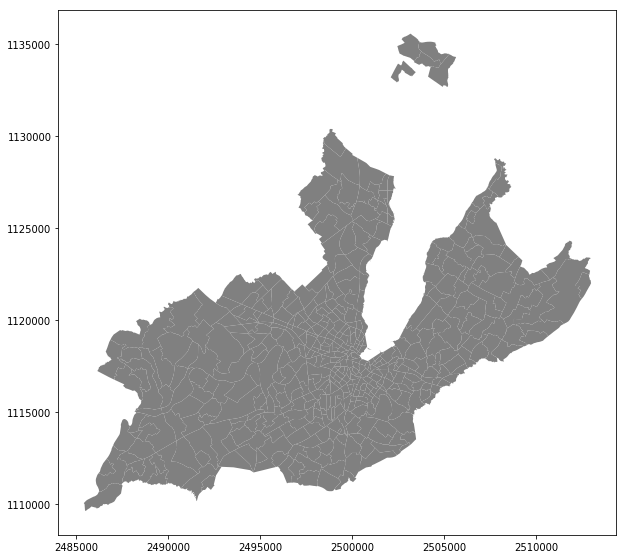

In [355]:
geneva_shp_file_path = str(shp_folder/"GEO_GIREC.shp")
geneva_bck = gpd.read_file(geneva_shp_file_path)
ax = geneva_bck.plot(figsize=(10,10),color = 'grey')
gdf.plot(column = 'Z_scores_spermvol',markersize = 5,cmap = 'bwr',scheme='fisher_jenks',ax = ax,legend = True)


In [ ]:
gdf['Z_scores_spermvol']

In [32]:
colors = ['white','blue','red','darkred','gray']
folium_map = dopemap.createMap(gdf,'lon','lat',10,14)
# Add additional tile style options
folium_map = dopemap.addTiles(folium_map,['Stamen Toner','CartoDB dark_matter'],14)
# Add Circle Markers at designed locations
    # Clustering points
dopemap.createMarkers(folium_map,gdf,'lon','lat','Fertility data points',['VOLUME_SPERME','lon','lat','geo_address','Z_scores_spermvol'],['Sperm Volume','Longitud','Latitud','Address','Z scores Sperm Volume'],'cat_zscore_spermvol',20,colors)
#Add legend to markers
legend_html = dopemap.createLegend(folium_map,gdf['cat_zscore_spermvol'],colors)
# Add heatmap
# dopemap.createHeatmap(folium_map,df_map,'lon','lat')
# Add fullscreen option
Fullscreen().add_to(folium_map)
# Add layer control
folium.LayerControl().add_to(folium_map)
# Save map 1A ########################################################################################
output_file = str(output_folder / 'Vol_sperm_Zscores.html')
folium_map.save(output_file)

0  markers added to the map!
1000  markers added to the map!
2000  markers added to the map!
3000  markers added to the map!
4000  markers added to the map!
5000  markers added to the map!
6000  markers added to the map!
7000  markers added to the map!
8000  markers added to the map!
9000  markers added to the map!
10000  markers added to the map!
11000  markers added to the map!
12000  markers added to the map!
13000  markers added to the map!
14000  markers added to the map!
15000  markers added to the map!
16000  markers added to the map!
17000  markers added to the map!


In [ ]:
colors = ['white','blue','red','darkred','gray']
folium_map = dopemap.createMap(gdf,'lon','lat',10,14)
# Add additional tile style options
folium_map = dopemap.addTiles(folium_map,['Stamen Toner','CartoDB dark_matter'],14)
# Add Circle Markers at designed locations
    # Clustering points
dopemap.createMarkers(folium_map,gdf,'lon','lat','Fertility data points',['VOLUME_SPERME','lon','lat','geo_address','Z_scores_spermvol'],['Sperm Volume','Longitud','Latitud','Address','Z scores Sperm Volume'],'cat_zscore_spermvol',20,colors)
#Add legend to markers
legend_html = dopemap.createLegend(folium_map,gdf['cat_zscore_spermvol'],colors)
# Add heatmap
# dopemap.createHeatmap(folium_map,df_map,'lon','lat')
# Add fullscreen option
Fullscreen().add_to(folium_map)
# Add layer control
folium.LayerControl().add_to(folium_map)
# Save map 1A ########################################################################################
output_file = str(output_folder / 'Vol_sperm_Zscores.html')
folium_map.save(output_file)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x136226d68>]],
      dtype=object)

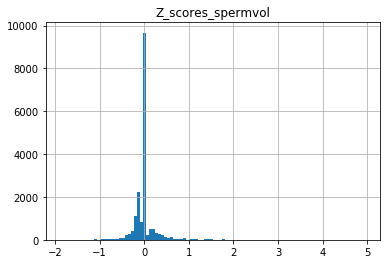

In [48]:
gdf.hist('Z_scores_spermvol',bins = 100)

In [33]:
test_gdf = gpd.read_file(str(shp_folder/'testing_fertility_to_delete.shp'))

In [34]:
test_gdf

,POLY_ID,XUFEFFN,AGE,DTNAISS,ADRESSE,CP,VILLE,DATEEXAM,VOLUME_SPE,CONCENTRAT,MOBILITE,full_addre,lon,lat,geo_addres,comment,clean_full,clean_addr,similarity,is_geocode,street_num,contains_c,contains_1,is_CH,is_address,contains_s,YEAREXAM,MONTHEXAM,DAYEXAM,Rank_pct_v,E,N,swiss_coor,swiss_co_1,G_STR,C_ID,PP_VAL,geometry
0,1,2758,37.0,9/20/1962,recordon 38,1004,lausanne,1999-08-23,0.05,778.0,29.0,recordon 38 1004 lausanne suisse,6.615335,46.527700,"avenue recordon 38, 1004 lausanne, switzerland",None,recordon 38 1004 lausanne suisse,recordon 38,74.358974,True,38,True,True,True,True,True,1999,8,23,"(-0.001, 25.0]",2.536832e+06,1.153266e+06,153265.966457,536832.047021,0.000052,2,0.001,POINT (2536832.047020521 1153265.966457052)
1,2,749,33.0,4/8/1968,milieu 30,1400,yverdon,2000-09-20,0.05,0.0,NaN,milieu 30 1400 yverdon suisse,6.638757,46.779101,"rue du milieu 30, 1400 yverdon-les-bains, swit...",None,milieu 30 1400 yverdon-les-bains suisse,milieu 30,78.260870,True,30,True,True,True,True,True,2000,9,20,"(-0.001, 25.0]",2.538914e+06,1.181193e+06,181193.230777,538914.446958,0.000059,1,0.003,POINT (2538914.446958286 1181193.230776767)
2,3,None,29.0,1/21/1975,beau sejour 28,1003,lausanne,2004-01-21,0.10,0.0,NaN,beau sejour 28 1003 lausanne suisse,6.637342,46.517366,"rue beau-séjour 28, 1003 lausanne, switzerland",None,beau sejour 28 1003 lausanne suisse,beau sejour 28,74.074074,True,28,True,True,True,True,True,2004,1,21,"(-0.001, 25.0]",2.538509e+06,1.152100e+06,152099.663945,538508.793411,0.000054,2,0.001,POINT (2538508.793410758 1152099.663945443)
3,4,None,32.0,5/23/1969,ancienne poste 9,1030,bussigny,2000-10-12,0.10,0.0,NaN,ancienne poste 9 1030 bussigny suisse,6.549962,46.548690,"rue de l&#39;ancienne-poste 9, 1030 bussigny, ...",None,ancienne poste 9 1030 bussigny suisse,ancienne poste 9,73.333333,True,9,True,True,True,True,True,2000,10,12,"(-0.001, 25.0]",2.531843e+06,1.155654e+06,155653.960635,531843.048806,0.000054,0,0.073,POINT (2531843.048806147 1155653.960634878)
4,5,6095,39.0,8/16/1963,rang du bas 11,1787,mur (vully),2002-04-22,0.10,15.0,7.0,rang du bas 11 1787 mur (vully) suisse,7.060579,46.942881,"rang du bas 11, 1787 mur (vully), switzerland",None,rang du bas 11 1787 mur (vully) suisse,rang du bas 11,84.337349,True,11,True,True,True,True,True,2002,4,22,"(-0.001, 25.0]",2.571216e+06,1.199158e+06,199158.008617,571215.973783,0.000061,0,0.100,POINT (2571215.973782856 1199158.008617261)
5,6,15826,33.0,10/17/1969,rue de lyon 45,1203,geneve,2002-04-08,0.10,0.0,NaN,rue de lyon 45 1203 geneve suisse,6.133826,46.208385,"rue de lyon 45, 1203 genève, switzerland",None,rue de lyon 45 1203 geneve suisse,rue de lyon 45,79.452055,True,45,False,True,True,True,True,2002,4,8,"(-0.001, 25.0]",2.499300e+06,1.118276e+06,118275.944124,499300.156690,0.000050,2,0.003,POINT (2499300.156689568 1118275.944123619)
6,7,6505,44.0,6/16/1965,rue du pont 11,1820,montreux,2008-08-23,0.10,230.0,19.0,rue du pont 11 1820 montreux suisse,6.916454,46.433411,"rue du pont 11, 1820 montreux, switzerland",None,rue du pont 11 1820 montreux suisse,rue du pont 11,83.116883,True,11,True,True,True,True,True,2008,8,23,"(-0.001, 25.0]",2.559865e+06,1.142586e+06,142586.002050,559865.028677,0.000060,1,0.016,POINT (2559865.028677336 1142586.002050181)
7,8,15975,60.0,6/18/1951,chatillon 31,2523,lignières,2010-07-31,0.10,1.0,9.0,chatillon 31 2523 lignières suisse,7.108464,47.095409,"châtillon 31, 2515 prêles, switzerland",None,chatillon 31 2523 lignières suisse,chatillon 31,61.111111,True,31,False,False,True,True,True,2010,7,31,"(-0.001, 25.0]",2.574933e+06,1.216098e+06,216098.236345,574933.422332,0.000009,2,0.002,POINT (2574933.422332217 1216098.236344803)
8,9,12528,33.0,1/9/1954,pl. du temple 16,1096,cully,1986-05-14,0.10,30.0,50.0,pl. du temple 16 1096 cully suisse,6.729348,46.488836,"place du temple 16, 1096 bourg-en-lavaux, swit...",None,pl du temple 16 1096 cully suisse,pl du temple 16,62.068966,True,16,False,True,True,True,True,1986,5,14,"(-0.001, 25.0]",2.545540e+06,1.1